In [18]:
import os
import sys
sys.path.append('/app/BreastAgeNet')

import openslide
import h5py
import numpy as np
import pandas as pd
from scipy import stats
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

from utils.utils_vis import *
from utils.utils_model import *
from utils.utils_vitattn import *

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
basedir = '/app/figures/Fig3'
os.listdir(basedir)

['train_NR_clean_10repeats.csv',
 'train_NR_tsne_HEoverlay.png',
 'train_NR_nuclei_morphology.csv',
 'SGK_cluster1_HE.png',
 'SGK_cluster2_HE.png',
 'SGK_cluster3_HE.png',
 'SGK_cluster0_HE.png']

In [20]:
# Load predictions of the train_NR dataset
train_df = pd.read_csv(f"{basedir}/train_NR_clean_10repeats.csv", low_memory=False)
print(len(train_df))

186488


In [21]:
# Perform t-SNE
tsne_df = train_df.drop_duplicates().copy()
print(len(tsne_df))

embedding_columns = [col for col in tsne_df.columns if col.startswith('embedding_')]
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(tsne_df.loc[:, embedding_columns])

tsne_df["tsne1"] = -projections[:,0]
tsne_df["tsne2"] = -projections[:,1]

108088


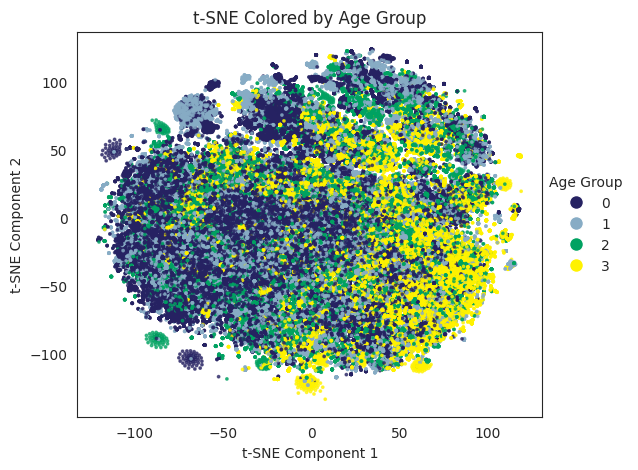

In [22]:
# t-SNE visualisation of ground-truth tissue ageing ranks 
plot_tsne(tsne_df, color='age_group', figsize=(6, 5), point_size=3, alpha=0.7, save_pt=None, ax=None)

In [23]:
# Global comparison of tsne1 and tsne2 features across ground-truth tissue ageing ranks (Kruskal-Wallis H-test)
compute_adjusted_pvalues_global(tsne_df, features=["tsne1", "tsne2"], group_label="age_group", group_order=[0, 1, 2, 3], save_pt=None)

,Feature,Comparison,Adjusted p-value,Significance
0,tsne1,All Groups,0.000000e+00,***
1,tsne2,All Groups,3.377031e-58,***


In [24]:
# Pairwise comparison of tsne1 and tsne2 features between ground-truth tissue ageing ranks (Wilcoxon rank-sum test)
group_colors = {0: '#262262', 1: '#87ACC5', 2: '#00A261', 3: '#FFF200'}
pval_df = compute_adjusted_pvalues(tsne_df, features=["tsne1", "tsne2"], group_label="age_group", group_order=[0, 1, 2, 3], save_pt=None)
pval_df

,Feature,Group 1,Group 2,Adjusted p-value,Significance
0,tsne1,0,1,1.142428e-139,***
1,tsne1,0,2,0.000000e+00,***
2,tsne1,0,3,0.000000e+00,***
3,tsne1,1,2,9.957184e-296,***
4,tsne1,1,3,0.000000e+00,***
5,tsne1,2,3,0.000000e+00,***
6,tsne2,0,1,7.320234e-01,
7,tsne2,0,2,3.916205e-02,*
8,tsne2,0,3,4.373477e-43,***
9,tsne2,1,2,9.840152e-02,


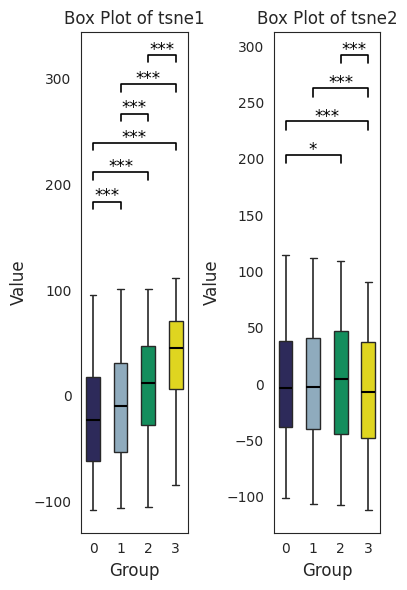

In [25]:
# Boxplot showing the pairwise comparison of tsne1 and tsne2 features between ground-truth tissue ageing ranks (Wilcoxon rank-sum test)
fig, axes = plt.subplots(1, 2, figsize=(4, 6))
for i, feature in enumerate(["tsne1", "tsne2"]):
    boxplot_with_pvalue(df=tsne_df, feature=feature, group_label="age_group", 
                    group_order=[0, 1, 2, 3], group_colors=group_colors, pval_df=pval_df, 
                        save_pt=None, ax=axes[i], figsize=(1, 5), box_width=0.5)

plt.tight_layout()
plt.show()

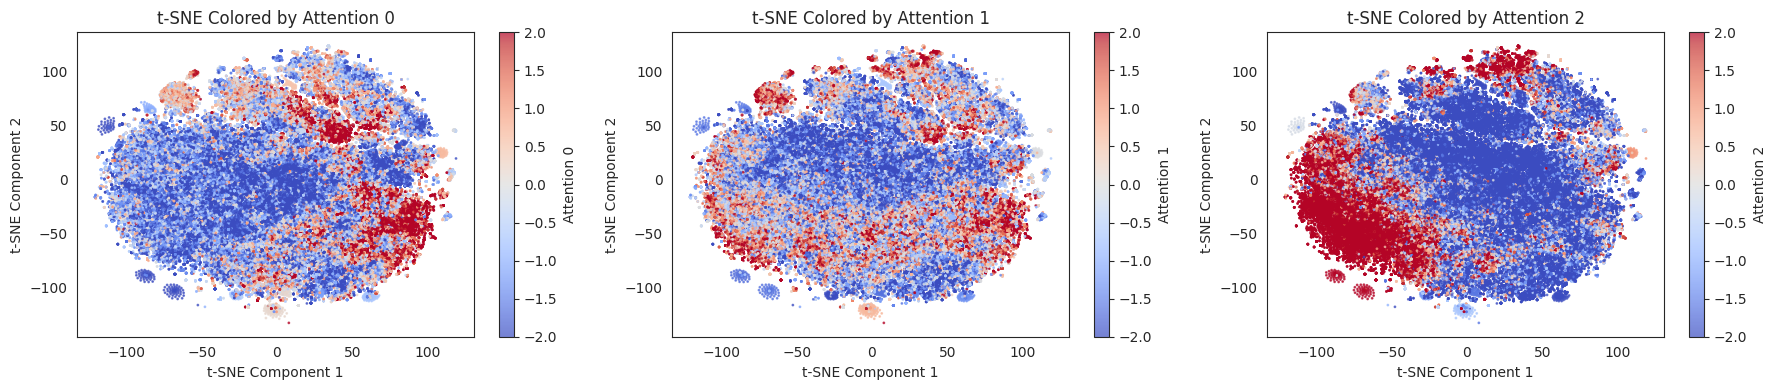

In [26]:
# t-SNE visualisation of branch-specific attention scores
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  

plot_tsne(tsne_df, color='attention_0', vmin=-2, vmax=2, point_size=1, ax=axes[0])
plot_tsne(tsne_df, color='attention_1', vmin=-2, vmax=2, point_size=1, ax=axes[1])
plot_tsne(tsne_df, color='attention_2', vmin=-2, vmax=2, point_size=1, ax=axes[2])

plt.tight_layout()
plt.show()

In [27]:
# Global comparison of branch-specific attention scores across ground-truth tissue ageing ranks (Kruskal-Wallis H-test)
compute_adjusted_pvalues_global(tsne_df, features=["attention_0", "attention_1", "attention_2"],
                                group_label="age_group", group_order=[0, 1, 2, 3], save_pt=None)

,Feature,Comparison,Adjusted p-value,Significance
0,attention_0,All Groups,0.000000e+00,***
1,attention_1,All Groups,7.634396e-119,***
2,attention_2,All Groups,0.000000e+00,***


In [28]:
# Pairwise comparison of branch-specific attention scores between ground-truth tissue ageing ranks (Wilcoxon rank-sum test)
group_colors = {0: '#262262', 1: '#87ACC5', 2: '#00A261', 3: '#FFF200'}
pval_df = compute_adjusted_pvalues(tsne_df, features=["attention_0", "attention_1", "attention_2"], 
                                   group_label="age_group", group_order=[0, 1, 2, 3], save_pt=None)
pval_df

,Feature,Group 1,Group 2,Adjusted p-value,Significance
0,attention_0,0,1,1.373965e-186,***
1,attention_0,0,2,0.000000e+00,***
2,attention_0,0,3,0.000000e+00,***
3,attention_0,1,2,6.092982e-215,***
4,attention_0,1,3,0.000000e+00,***
5,attention_0,2,3,0.000000e+00,***
6,attention_1,0,1,2.543703e-21,***
7,attention_1,0,2,1.023102e-99,***
8,attention_1,0,3,2.198353e-01,
9,attention_1,1,2,3.383548e-33,***


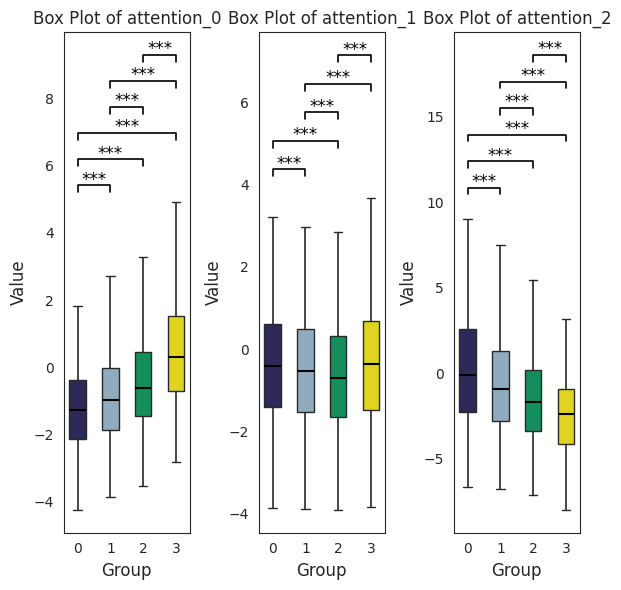

In [29]:
# Boxplot showing the pairwise comparison of branch-specific attention scores between ground-truth tissue ageing ranks (Wilcoxon rank-sum test)
fig, axes = plt.subplots(1, 3, figsize=(6, 6))

for i, feature in enumerate(["attention_0", "attention_1", "attention_2"]):
    boxplot_with_pvalue(
        df=tsne_df, 
        feature=feature, 
        group_label="age_group", 
        group_order=[0,1,2,3], 
        group_colors=group_colors, 
        pval_df=pval_df, 
        save_pt=None, 
        ax=axes[i], 
        figsize=(1, 5), 
        box_width=0.5
    )

plt.tight_layout()
plt.show()

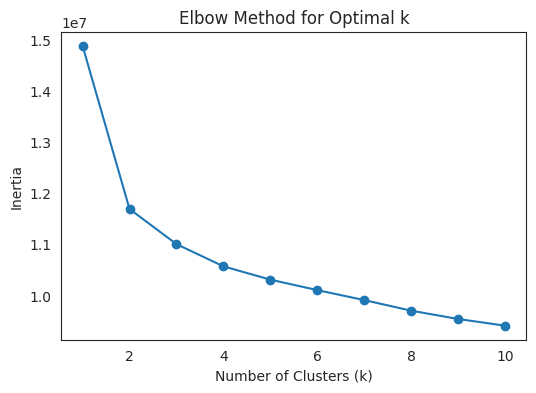

In [30]:
# identify optimal K for Kmeans
k_range = range(1, 11)
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_df.loc[:, embedding_columns])  
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

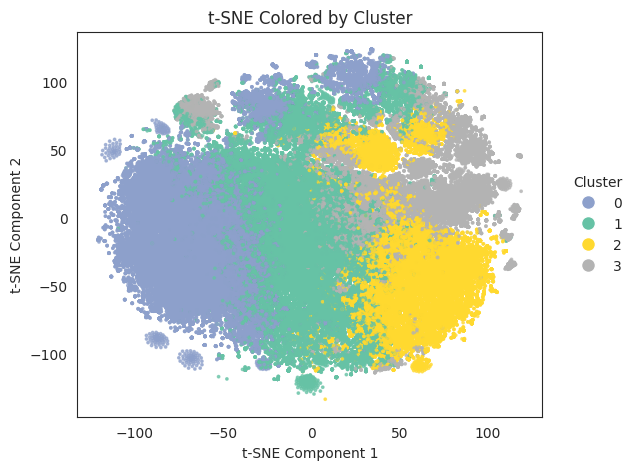

In [55]:
# Perform Kmeans
n_clusters = 4  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(tsne_df.loc[:, embedding_columns].copy())
mapping = {0: 0, 1: 2, 2: 1, 3: 3}
tsne_df["Cluster"] = tsne_df["Cluster"].map(mapping)
tsne_df['Pattern'] = [f"P{i}" for i in list(tsne_df['Cluster'])]
plot_tsne(tsne_df, color='Cluster', figsize=(6, 5), point_size=3, alpha=0.7, save_pt=None)

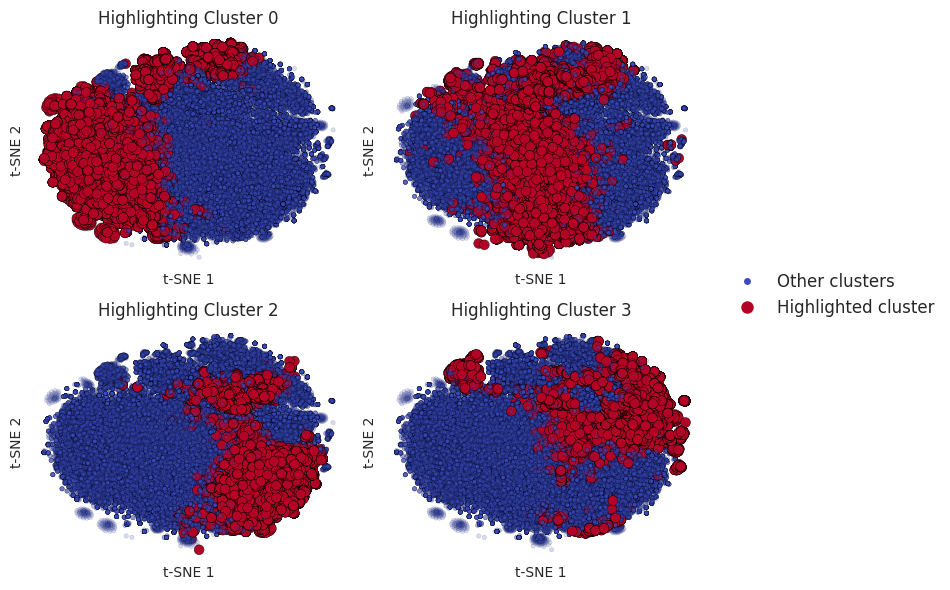

In [56]:
# Visualise each cluster in the t-SNE plot
highlight_pattern_in_tsne(tsne_df, label='Cluster', cmap="coolwarm", max_size=50, min_size=10, max_alpha=1.0, min_alpha=0.2, figsize=(8, 6), save_pt=None)

(-0.5, 3948.5, 2960.5, -0.5)

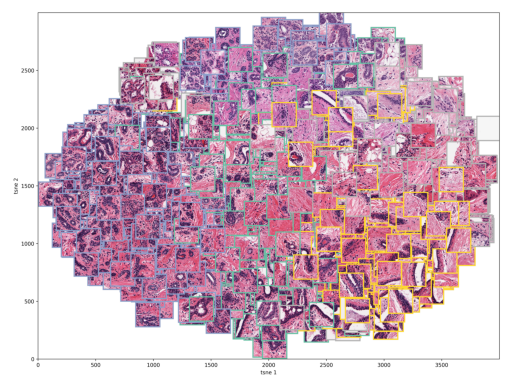

In [47]:
# overlayed H&E images
# cluster_colors = {0: '#8da0cb', 1: '#66c2a5', 2: '#ffd92f', 3: '#b3b3b3'}
# full_image = paste_HE_on_tsne(tsne_df=tsne_df, WSI_folder='/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/WSIs',
#                      cluster_colors=cluster_colors, max_dim=200, n_samples=500, image_size=(4000, 3000), random_state=42)

# plt.figure(figsize=(16, 12))
# plt.imshow(full_image)
# plt.xlabel("tsne 1")
# plt.ylabel("tsne 2")
# plt.gca().invert_yaxis()  
# save_pt = f"{save_prefix}_tsne_HEoverlay.png"
# plt.savefig(fname = save_pt, dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.imshow(Image.open(f"{basedir}/train_NR_tsne_HEoverlay.png"))
plt.axis('off')

In [35]:
# # save clustering results
# tsne_df['Pattern'] = [f"P{i}" for i in list(tsne_df['Cluster'])]
# tsne_df.to_csv(f"{save_prefix}_tsne_4clusters.csv", index=False)

# # Visualise cluster examples
# fig, axs = plt.subplots(2, 2, figsize=(12, 12)) 
# axs = axs.flatten()

# for i, cluster_id in enumerate([0, 1, 2, 3]):
#     cluster_imgs = get_Cluster_example(tsne_df, cluster_id, im_num=16)

#     save_pt = f"{save_prefix}_Cluster{cluster_id}_examples.png"
#     plot_multiple(cluster_imgs, caption_list=None, grid_x=4, grid_y=4, figure_size=(8, 8), title=f"Cluster {cluster_id}", save_pt=save_pt)

#     im = Image.open(save_pt)
#     axs[i].imshow(im)
#     axs[i].axis('off')  
    
# plt.tight_layout()
# plt.savefig(f"{save_prefix}_4_clusters_2x2grid.png", dpi=300, bbox_inches='tight')
# plt.show()

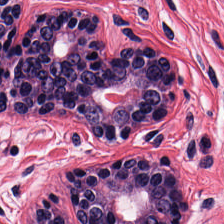

In [36]:
# MHSA heatmaps
im_pt = f"{basedir}/SGK_cluster0_HE.png"
patch = Image.open(im_pt)
patch

torch.Size([16, 196])


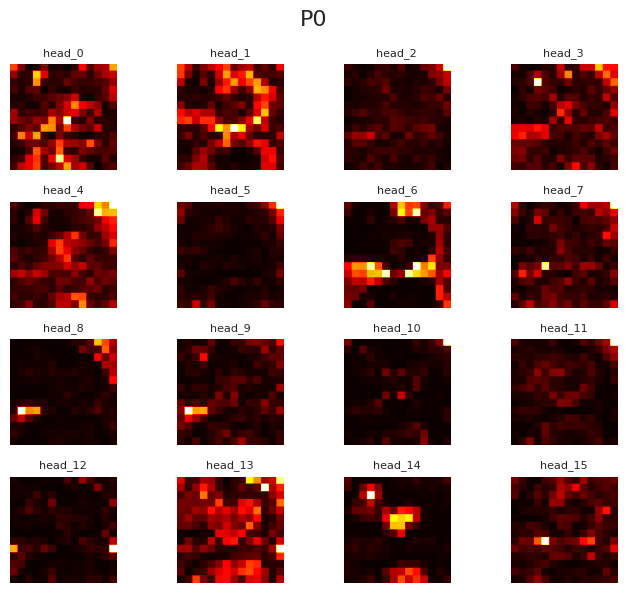

In [37]:
th_attn, attentions = get_attentions_lastlayer(patch, threshold=0.6)
fig = plot_multiple(img_list = attentions, caption_list= [f"head_{i}" for i in range(16)], 
              grid_x=4, grid_y=4, figure_size=(7, 6), title="P0", cmap= 'hot', save_pt=None)

In [ ]:
im_pt = f"{basedir}/SGK_cluster1_HE.png"
patch = Image.open(im_pt)
patch

In [ ]:
th_attn, attentions = get_attentions_lastlayer(patch, threshold=0.6)
fig = plot_multiple(img_list = attentions, caption_list= [f"head_{i}" for i in range(16)], 
              grid_x=4, grid_y=4, figure_size=(7, 6), title="P1", cmap= 'hot', save_pt=None)

In [ ]:
im_pt = f"{basedir}/SGK_cluster2_HE.png"
patch = Image.open(im_pt)
patch

In [ ]:
th_attn, attentions = get_attentions_lastlayer(patch, threshold=0.6)
fig = plot_multiple(img_list = attentions, caption_list= [f"head_{i}" for i in range(16)], 
              grid_x=4, grid_y=4, figure_size=(7, 6), title="P2", cmap= 'hot', save_pt=None)

In [ ]:
im_pt = f"{basedir}/SGK_cluster3_HE.png"
patch = Image.open(im_pt)
patch

In [ ]:
th_attn, attentions = get_attentions_lastlayer(patch, threshold=0.6)
fig = plot_multiple(img_list = attentions, caption_list= [f"head_{i}" for i in range(16)], 
              grid_x=4, grid_y=4, figure_size=(7, 6), title="P3", cmap= 'hot', save_pt=None)

In [52]:
# Load nuclei morphology quantification results table
nuclei_csv = f"{basedir}/train_NR_nuclei_morphology.csv"   
nuclei_df = pd.read_csv(nuclei_csv)

# merge nuclei table with cluster results
nuclei_df = pd.merge(nuclei_df, tsne_df.loc[:, ['patch_id', 'Cluster', 'Pattern']], on = 'patch_id')
nuclei_df.head()

,label,area,bbox_area,extent,eccentricity,perimeter,major_axis_length,minor_axis_length,solidity,Circularity,Elongation,patch_id,coord_x,coord_y,Cluster,Pattern
0,1,193.0,256.0,0.753906,0.451388,49.455844,16.594833,14.808031,0.955446,8.806866,1.120664,K108959_48774_4217_5561_4543_196_29_254,260,310,2,P2
1,2,146.0,182.0,0.802198,0.505477,42.384776,14.692902,12.677623,0.966887,8.498603,1.158964,K108959_48774_4217_5561_4543_196_29_254,108,334,2,P2
2,3,103.0,130.0,0.792308,0.734347,36.142136,13.913546,9.444152,0.953704,6.686078,1.473245,K108959_48774_4217_5561_4543_196_29_254,292,266,2,P2
3,4,116.0,154.0,0.753247,0.703764,38.970563,14.417547,10.242713,0.928000,7.012697,1.407591,K108959_48774_4217_5561_4543_196_29_254,150,190,2,P2
4,5,145.0,195.0,0.743590,0.730952,43.798990,16.517790,11.272219,0.947712,6.678424,1.465354,K108959_48774_4217_5561_4543_196_29_254,206,212,2,P2


In [53]:
# aggregate the nuclei table --> patch table
agg_df = nuclei_df.groupby('patch_id').agg(
    area_mean=('area', 'mean'),
    bbox_area_mean=('bbox_area', 'mean'),
    extent_mean=('extent', 'mean'),
    eccentricity_mean=('eccentricity', 'mean'),
    perimeter_mean=('perimeter', 'mean'),
    major_axis_length_mean=('major_axis_length', 'mean'),
    minor_axis_length_mean=('minor_axis_length', 'mean'),
    solidity_mean=('solidity', 'mean'),
    circularity_mean=('Circularity', 'mean'),
    elongation_mean=('Elongation', 'mean'),
    nuclei_count=('patch_id', 'size'),  
    cluster=('Cluster', lambda x: x.mode()[0]),
    Pattern=('Pattern', lambda x: x.mode()[0])  
).reset_index()

agg_df.head()

,patch_id,area_mean,bbox_area_mean,extent_mean,eccentricity_mean,perimeter_mean,major_axis_length_mean,minor_axis_length_mean,solidity_mean,circularity_mean,elongation_mean,nuclei_count,cluster,Pattern
0,K105969_2972_9656_3044_2787_15_43_256,1926.000000,2708.800000,0.706233,0.772057,149.502352,52.190686,32.107092,0.915998,5.510506,1.865560,50,3,P3
1,K105969_2972_9656_3044_2787_15_44_256,1915.400000,2578.000000,0.738072,0.639098,139.942554,47.754058,32.401593,0.934293,7.139259,1.402992,45,1,P1
2,K105969_2972_9656_3044_2787_16_42_256,999.818182,1459.363636,0.697358,0.751534,96.364571,34.486588,21.056789,0.933886,6.116491,1.677656,44,3,P3
3,K105969_2972_9656_3044_2787_16_43_256,1994.142857,2844.000000,0.721325,0.600732,151.473114,49.192441,34.640658,0.914795,7.461392,1.318308,35,1,P1
4,K105969_2972_9656_3044_2787_16_45_256,1628.833333,2256.833333,0.746006,0.507165,124.475818,41.614155,28.572540,0.929036,7.954212,1.264657,18,0,P0


In [57]:
# Pairwise comparison of nuclei morphology quantifications between phenotypes P0-P3 (Wilcoxon rank-sum test)
features = ['nuclei_count', 'area_mean', "perimeter_mean", "major_axis_length_mean", 
            "minor_axis_length_mean", "extent_mean", 'circularity_mean', 'elongation_mean', 
            "eccentricity_mean", "solidity_mean"]
pval_df = compute_adjusted_pvalues(df=agg_df, features=features, 
                                   group_label="Pattern", group_order = ['P0', 'P1', 'P2', 'P3'], save_pt=None)
pval_df.head()

,Feature,Group 1,Group 2,Adjusted p-value,Significance
0,nuclei_count,P0,P1,5.863002e-18,***
1,nuclei_count,P0,P2,6.213799e-150,***
2,nuclei_count,P0,P3,0.000000e+00,***
3,nuclei_count,P1,P2,3.459095e-71,***
4,nuclei_count,P1,P3,9.594220e-232,***


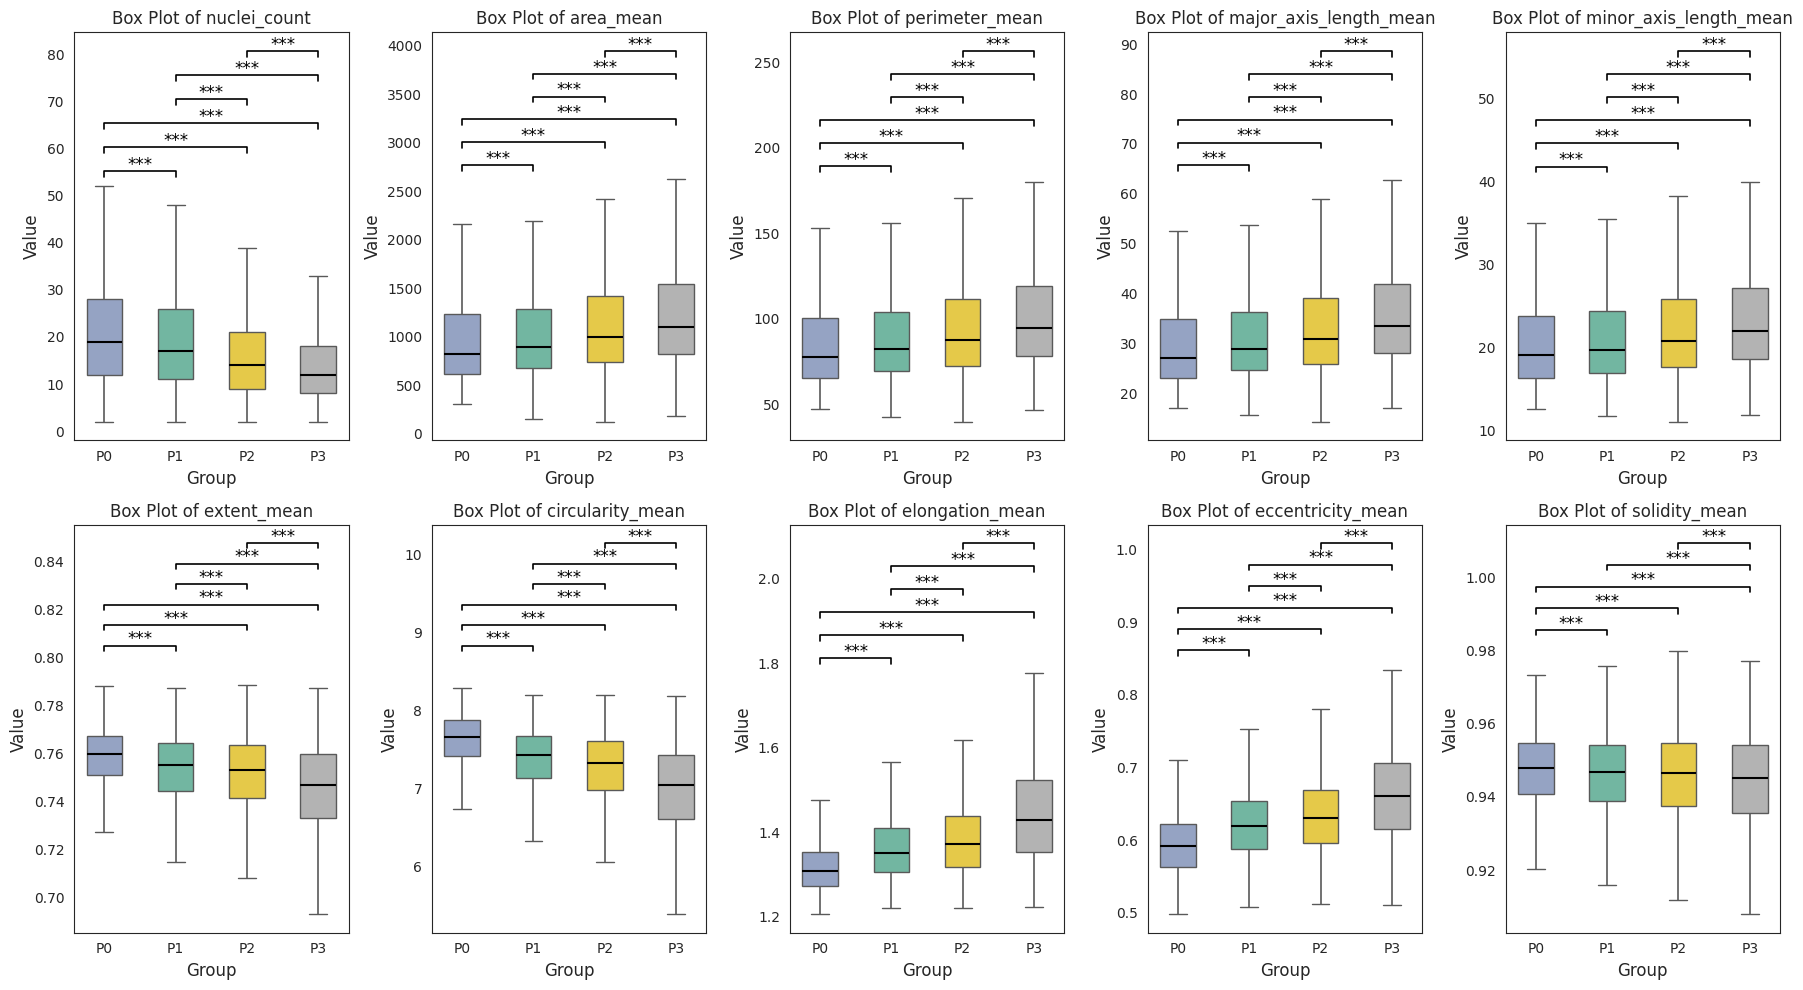

In [58]:
# Boxplot showing the pairwise comparison of nuclei morphology quantifications between phenotypes P0-P3 (Wilcoxon rank-sum test)
cluster_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

fig, axes = plt.subplots(2, 5, figsize=(18, 10))  
axes = axes.flatten()
for i, feature in enumerate(features):
    boxplot_with_pvalue(agg_df, feature, group_label='Pattern', group_order=['P0', 'P1', 'P2', 'P3'], group_colors=cluster_colors, pval_df=pval_df, ax=axes[i])

plt.tight_layout()
plt.show()

In [59]:
# Comparison of the abundance of phenotypes P0-P3 across ground-truth tissue ageing ranks (Chi-square test)
contingency_table = pd.crosstab(tsne_df["age_group"], tsne_df["Pattern"])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
significance = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'

print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4e} {significance}")
if significance != 'ns':
    print(f"Significant association found between age_group and Pattern ({significance}).")
else:
    print("No significant association found between age_group and Pattern.")

Chi-square statistic: 17722.3041
Degrees of freedom: 9
P-value: 0.0000e+00 ***
Significant association found between age_group and Pattern (***).


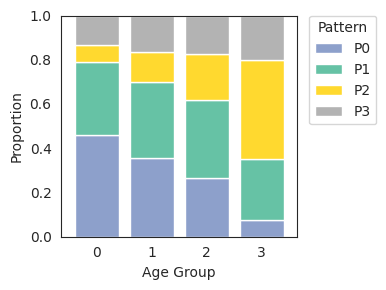

In [60]:
# Stacked barplot showing the abundance of phenotypes P0-P3 across ground-truth tissue ageing ranks
age_group_order = [0, 1, 2, 3]
pattern_order = ["P0", "P1", "P2", "P3"]
group_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}
counts = tsne_df.groupby(["age_group", "Pattern"]).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0)
proportions = proportions.loc[age_group_order, pattern_order]

fig, ax = plt.subplots(figsize=(4, 3))
proportions.plot(kind="bar", stacked=True, color=[group_colors[p] for p in pattern_order], ax=ax, width=0.8)
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_xticklabels(age_group_order, rotation=0)
ax.set_ylim(0, 1)  # Ensure y-axis goes from 0 to 1
ax.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

In [61]:
# Pairwise comparison of branch-specific attention scores between phenotypes P0-P3 (Wilcoxon rank-sum test)
pval_df = compute_adjusted_pvalues(df=tsne_df, features=["attention_0", "attention_1", "attention_2"], 
                                   group_label="Pattern", group_order = ['P0', 'P1', 'P2', 'P3'], save_pt=None)
pval_df

,Feature,Group 1,Group 2,Adjusted p-value,Significance
0,attention_0,P0,P1,6.119695e-12,***
1,attention_0,P0,P2,0.000000e+00,***
2,attention_0,P0,P3,5.248388e-248,***
3,attention_0,P1,P2,0.000000e+00,***
4,attention_0,P1,P3,2.663814e-139,***
5,attention_0,P2,P3,0.000000e+00,***
6,attention_1,P0,P1,0.000000e+00,***
7,attention_1,P0,P2,1.905536e-102,***
8,attention_1,P0,P3,0.000000e+00,***
9,attention_1,P1,P2,0.000000e+00,***


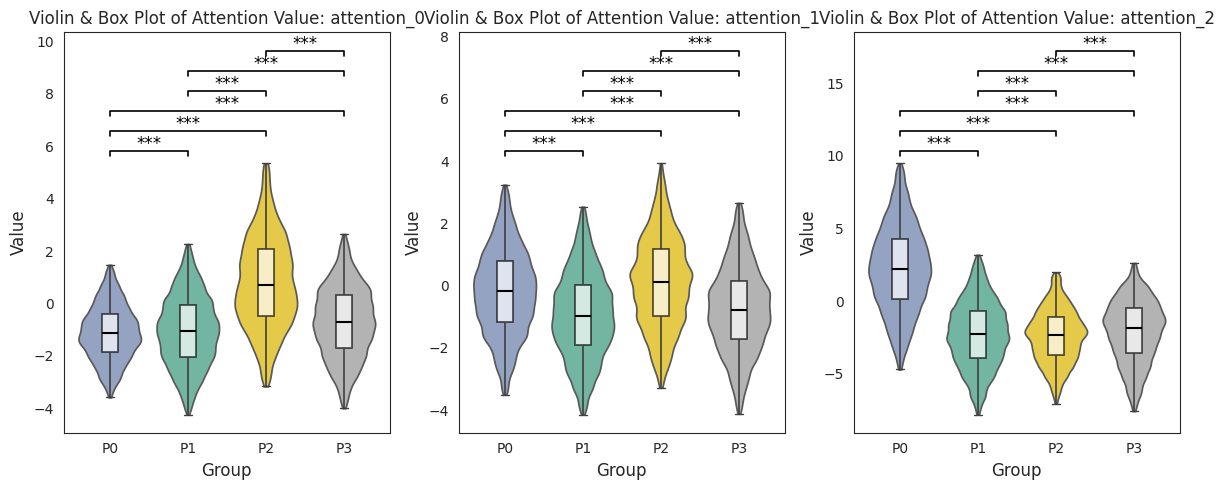

In [62]:
# Violin plot showing the pairwise comparison of branch-specific attention scores between phenotypes P0-P3 (Wilcoxon rank-sum test)
group_label = 'Pattern'
group_order = ['P0', 'P1', 'P2', 'P3']
group_colors = {'P0': '#8da0cb', 'P1': '#66c2a5', 'P2': '#ffd92f', 'P3': '#b3b3b3'}

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, feature in enumerate(["attention_0", "attention_1", "attention_2"]):
    violin_boxplot_with_pvalue(tsne_df, feature, group_label, group_order, group_colors, pval_df, ax=axes[i])

plt.tight_layout()
plt.show()